---
# Stroke Prediction: A Machine Learning Approach

This project uses machine learning to predict the likelihood of stroke based on patient health data. 

**Author:** Martynas Loveikis

---

## Table of Contents

* [Data Quirks](#data-quirks)
* [Target Population](#target-population)
* [Data Splitting](#data-splitting)
* [Data Exploration](#data-exploration)
* [Preprocessing](#preprocessing)
* [Statistical Analysis](#statistical-analysis)
* [Baseline Modeling](#baseline-modeling)
* [Undersampling](#undersampling)
* [Ensemble Models](#ensemble-models)
    * [Random Forest](#random-forest)
    * [XGBoost](#xgboost)
* [Hyperparameter Tuning](#hyperparameter-tuning)
* [Model Evaluation](#model-evaluation)
* [XGBoost Visualization](#xgboost-visualization)
* [Model Saving](#model-saving)
* [Conclusion](#conclusion) 

In [1]:
"""
This notebook builds a machine learning model to predict the likelihood of stroke.

It includes data loading, preprocessing, model training, evaluation, and saving the model.
"""

import warnings
import pickle
from pathlib import Path
import os

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OrdinalEncoder,
    RobustScaler,
)
import xgboost as xgb

import model_utilities as f
import plots_utilities as plot
import stats_utilities as stats

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

CITRINE = "#e9cb0c"
NAPLES = "#ffd470"
CREAM = "#f3f6cb"
APPLE = "#9ea300"
MOSS = "#555610"

ml_colors = [MOSS, APPLE, CREAM, NAPLES, CITRINE]
cmap = plt.cm.colors.ListedColormap(ml_colors)

In [2]:
df = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")
df = df.drop("id", axis=1)
df.columns = df.columns.str.lower()

In [3]:
X = df.copy()
y = X.pop("stroke")

In [4]:
f.check_df(df)

############## Shape ##############


(5110, 11)


############## Quantiles ##############


,count,mean,std,min,0%,5%,50%,95%,99%,100%,max
age,5110.0,43.226614,22.612647,0.08,0.08,5.0000,45.000,79.0000,82.0000,82.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.00,0.0000,0.000,1.0000,1.0000,1.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.00,0.0000,0.000,1.0000,1.0000,1.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,55.12,60.7135,91.885,216.2945,240.7082,271.74,271.74
bmi,4909.0,28.893237,7.854067,10.30,10.30,17.6400,28.100,42.9600,53.4000,97.60,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.00,0.0000,0.000,0.0000,1.0000,1.00,1.00



############## Types ##############
              gender: object
                 age: float64
        hypertension: int64
       heart_disease: int64
        ever_married: object
           work_type: object
      residence_type: object
   avg_glucose_level: float64
                 bmi: float64
      smoking_status: object
              stroke: int64

############## Head ##############


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1



############## Tail ##############


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0



############## NA ##############


gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


############## Duplicate Rows ##############
No duplicate rows found in the DataFrame.


## Data Quirks

Ah, our dataset, a mischievous imp with a penchant for inconsistency and a flair for the dramatic.

*   **Boolean Bonanza:**  A delightful mix of 0/1 and True/False values for boolean features. Because who needs standardization anyway?
*   **Missing BMI Blues:**  Some missing `bmi` values, adding a touch of mystery to the mix. We'll just fill in the blanks with our best guesses and hope for the best.
*   **Uniqueness is Key:** No duplicate rows, thankfully. We wouldn't want our dataset to be accused of plagiarism.
*   **Stroke Imbalance:** A heavily imbalanced `stroke` feature (95% "no stroke").  Predicting rare events is always a joy, isn't it?

Despite these quirks, we shall persevere, like intrepid explorers venturing into uncharted territory. Who knows what treasures we may uncover beneath the surface of this unruly dataset?

## Target Population

Target Population: Stroke Survivors 🧠

Our dataset focuses on individuals who have experienced a stroke, a rather exclusive (and hopefully not rapidly growing) club.

## Data Splitting

Data splitting: the ancient ritual where we arbitrarily divide our data into three piles, hoping to appease the gods of machine learning. We'll pretend these proportions hold deep meaning while secretly fearing our model might choke on its own success.

### The Holy Trinity of Data Splits (or, How to Fake Confidence in Our Data Sorcery)

*   **Training (60%):** The data feast where our model will stuff itself silly, desperately seeking patterns in the vast expanse of digital noise.
*   **Validation (20%):** A meager offering to the overfitting gods, just enough to keep our model from memorizing the training data like a parrot with an eidetic memory.
*   **Testing (20%):** The final showdown, where our model's true colors will be revealed. Will it emerge victorious, or crash and burn in a spectacular display of algorithmic incompetence?

In [5]:
X_train_val, X_test, y_train_val, y_test = (
    train_test_split(X, y, test_size=0.2, random_state=42, stratify=y))
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25,
    random_state=42, stratify=y_train_val
)

In [6]:
categorical_cols = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "residence_type",
    "smoking_status",
]
numerical_features = ["age", "avg_glucose_level", "bmi"]

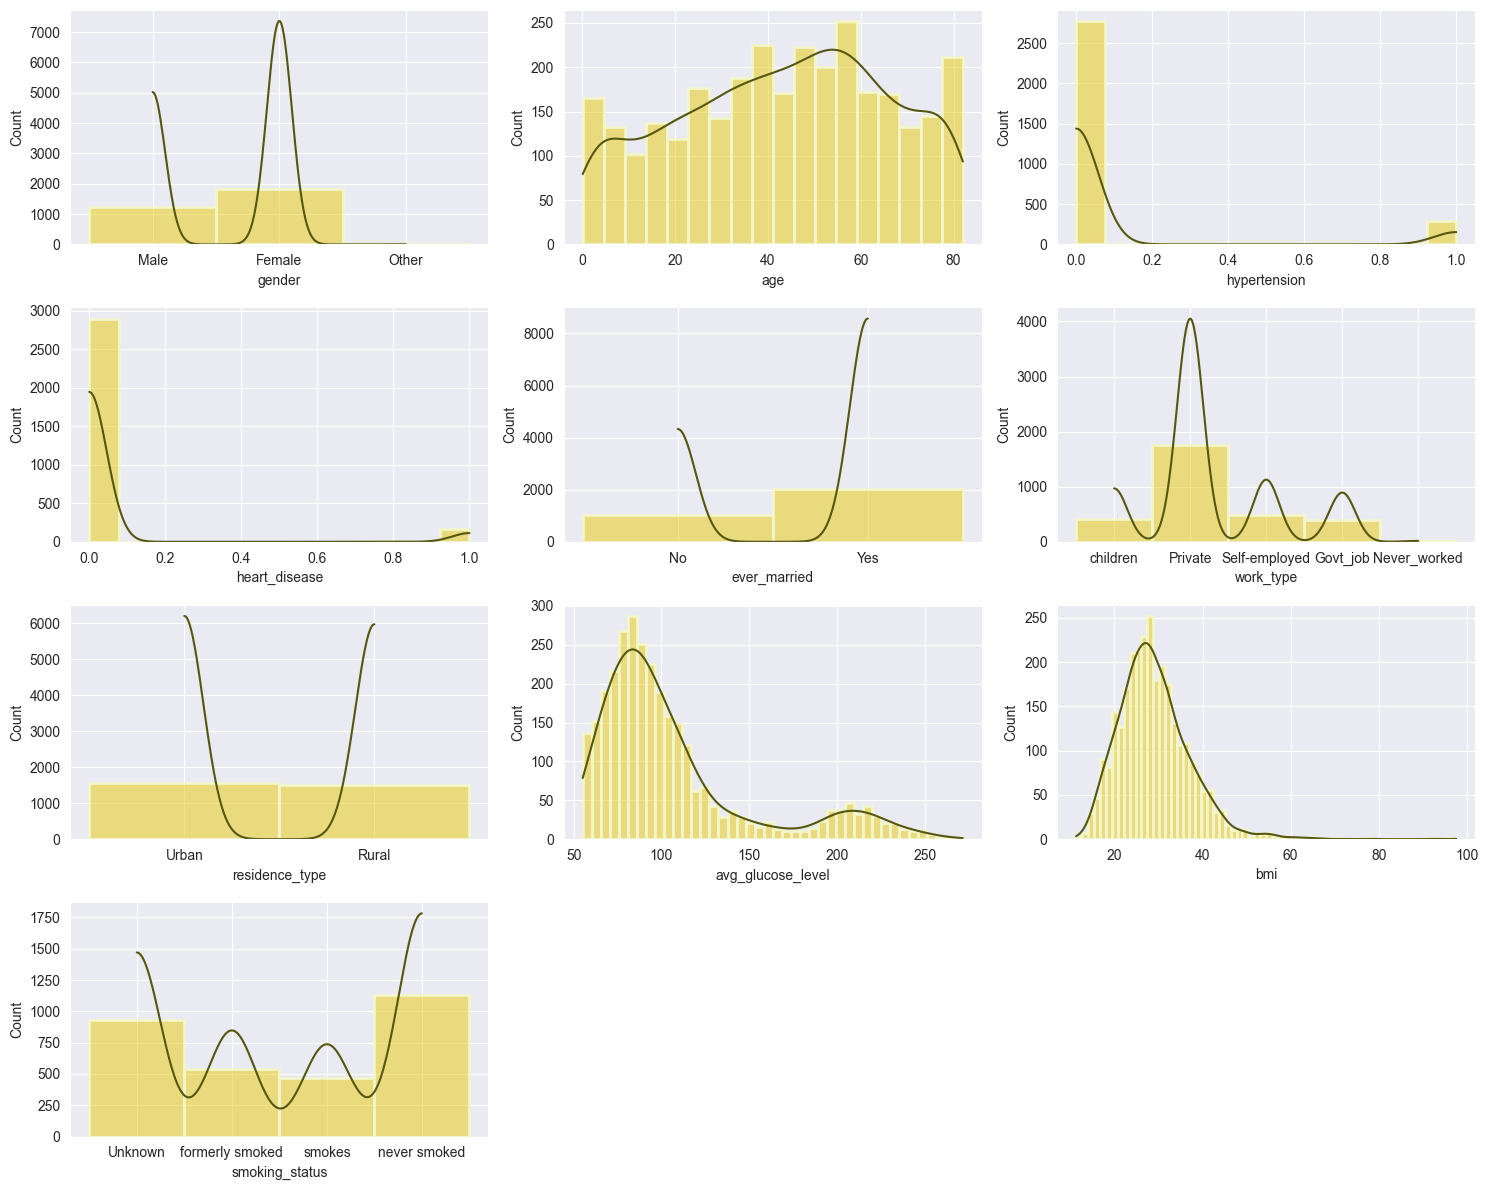

In [7]:
plot.dynamic_plots(X_train)

## Data Exploration

Our dataset, it seems, is a rebellious teenager, flaunting its imbalances and skews with reckless abandon.  

*   **`heart_disease`, `ever_married`, `hypertension`**: These categorical features are playing hard to get, making rare events even more elusive. How delightful.

*   **`avg_glucose_level`, `bmi`**:  Skewed to the right, these numerical features clearly have a taste for the extreme.  Outliers, it seems, are the life of the party.

*   **`age`**:  The lone voice of reason, uniformly distributed and unfazed by the chaos.  Someone needs to keep things grounded.

Of course, we can't let these quirks slide. We'll need to whip our models into shape, lest they be seduced by the allure of biased results. But for now, let's appreciate the absurdity of it all.  After all, who needs perfect data when you have irony?


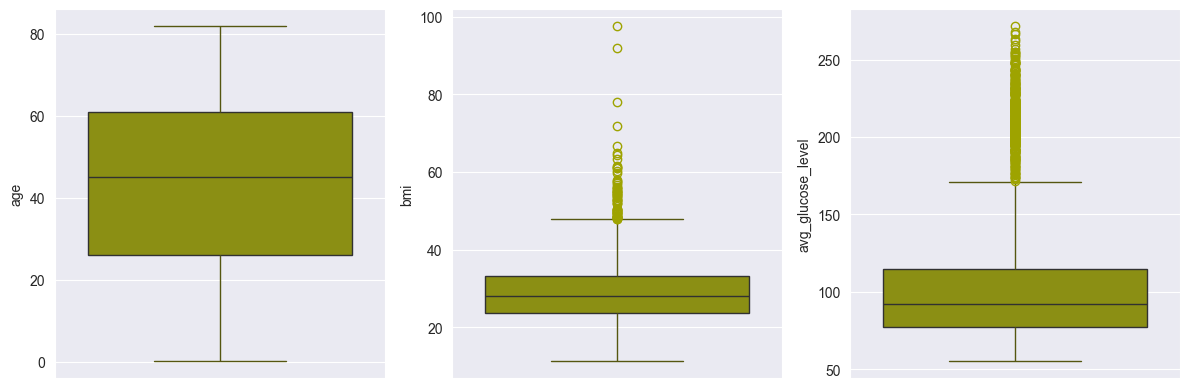

In [8]:
plot.dynamic_plots(
    X_train.loc[:, ["age", "bmi", "avg_glucose_level"]],
    plot_type="boxplot",
    figsize=(12, 4),
)

Outliers? In medical data?  Never! We shall embrace every data point, no matter how absurd, in our noble quest to predict strokes. Who knows, maybe those bizarre BMIs hold the key to medical breakthroughs. Or maybe not. But we'll keep them anyway, just in case.

In [9]:
X_train_full = pd.concat([X_train, y_train], axis=1)

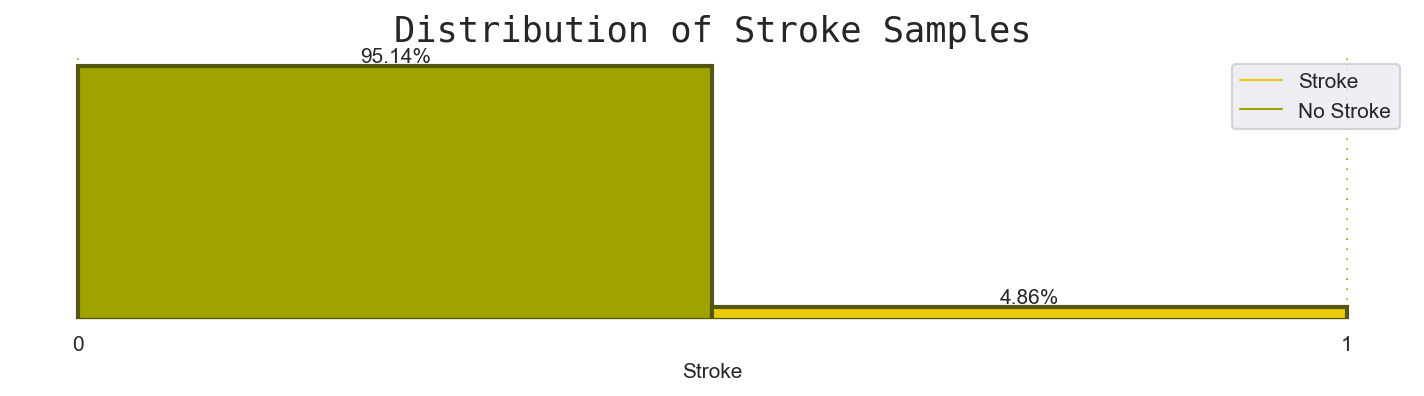

In total 149 people have had a stroke


In [10]:
plot.stroke_distribution(X_train_full)
print(
    f"In total {X_train_full[X_train_full['stroke'] == 1].shape[0]}"
    f" people have had a stroke"
)

Ah, yes, the classic imbalanced class problem.  It seems our dataset has a strong preference for "no stroke," with a staggering 95% of the data conforming to this rather dull outcome.  Predicting rare events is always a challenge, but hey, who needs easy wins?  Let's see if we can coax our model into detecting those elusive strokes, shall we?

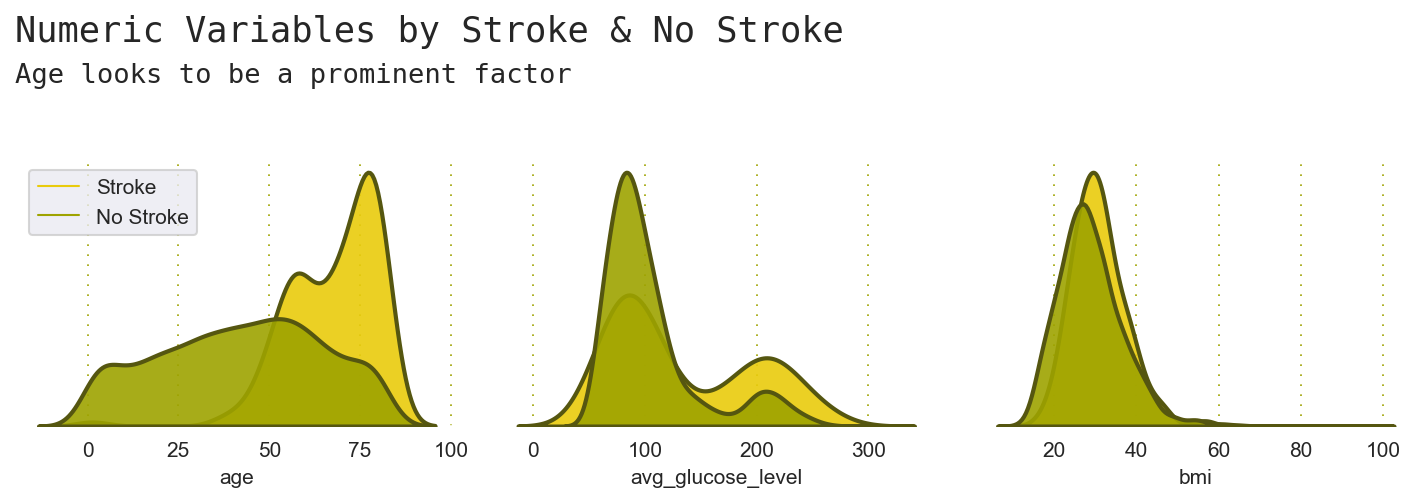

In [11]:
plot.numeric_variables_by_stroke(X_train_full)

Age, it seems, is the ultimate predictor of stroke.  Who knew?  As for the other numerical features, they seem rather indifferent to the presence or absence of a stroke.  Perhaps they're just too cool to care, or maybe they're secretly plotting their own rebellion against our predictive models.  Either way, we'll keep a close eye on them.

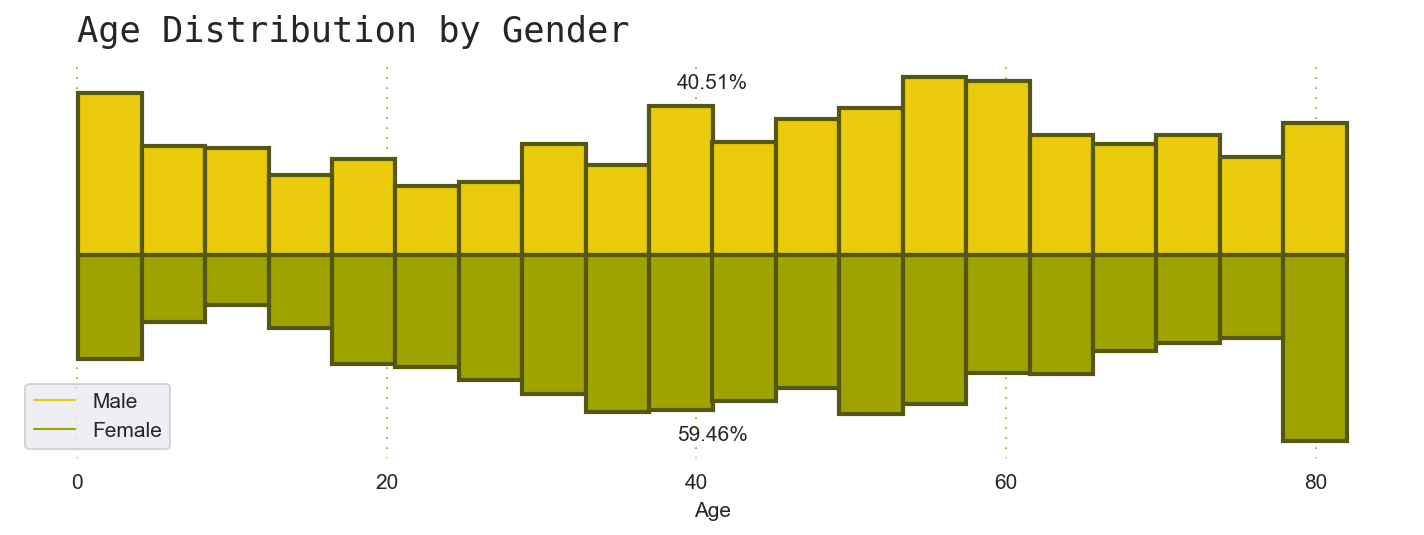

In [12]:
plot.age_distribution_by_gender(X_train_full)

In [13]:
chi_test = stats.chi_squared_test([41,59],[50,50])

Chi-squared Test Results:
  Chi-squared statistic: 1.29
  P-value: 0.256
  Degrees of freedom: 1

Interpretation: There is no statistically significant difference between the observed and expected frequencies.


Gender: the capricious variable that adds a touch of intrigue (and potential bias) to our stroke prediction quest.  Our models, armed with data and a dash of sardonicism, shall fearlessly navigate the complexities of gender-based predictions.

In [14]:
binning_transformer = Pipeline(
    steps=[
        ("binning", KBinsDiscretizer(n_bins=5, encode="ordinal",
                                     strategy="uniform")),
        ("rescale", FunctionTransformer(f.rescale_function)),
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("ordinal", OrdinalEncoder()),
        ("rescale", FunctionTransformer(f.rescale_function)),
    ]
)
numerical_transformer = Pipeline(
    steps=[
        ("robust", RobustScaler()),
    ]
)

## Preprocessing

Data preprocessing: the art of taming wild data and transforming it into a docile pet for our models. Ordinal encoding, scaling, and age-based binning—because who needs the thrill of raw data when you can have a predictable playground for your algorithms?

In [15]:
pipelined_features = categorical_cols + numerical_features

pipelined_features.insert(0, "age_binned")

pipelined_features.extend(
    [
        "age*gender",
        "bmi*gender",
        "hypertension*age_binned",
        "heart_disease*age_binned",
        "smoking*age_binned",
        "avg_glucose*age",
    ]
)
pipelined_features

['age_binned',
 'gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'residence_type',
 'smoking_status',
 'age',
 'avg_glucose_level',
 'bmi',
 'age*gender',
 'bmi*gender',
 'hypertension*age_binned',
 'heart_disease*age_binned',
 'smoking*age_binned',
 'avg_glucose*age']

Column renaming: a nostalgic nod to human-readable labels in a world of soulless numerical arrays. We shall preserve those precious column names, like ancient artifacts in a museum of data.

In [16]:
pipeline = Pipeline(
    steps=[
        ("bmi_imputer", FunctionTransformer(f.predict_bmi)),
        (
            "preprocessor",
            ColumnTransformer(
                transformers=[
                    ("age_bins", binning_transformer, ["age"]),
                    ("ordinal_boolean", categorical_transformer,
                     categorical_cols),
                    ("numerical_scale", numerical_transformer,
                     numerical_features),
                ]
            ),
        ),
        ("interaction_terms", FunctionTransformer(f.create_interactions)),
    ]
)

The grand pipeline: a meticulously choreographed ballet of data transformations. Imputation, scaling, and feature engineering—because who needs simplicity when you can have a labyrinth of interconnected variables?

In [17]:
X_val_pipelined = f.preprocess_data(X_val, pipeline, pipelined_features)
X_test_pipelined = f.preprocess_data(X_test, pipeline, pipelined_features)
X_train_pipelined = f.preprocess_data(X_train, pipeline, pipelined_features)

## Statistical Analysis

Ah, the return to normalcy. After subjecting our data to a whirlwind of transformations, we graciously restore it to its original DataFrame form. Because who needs numpy arrays when you can have a beautiful, human-readable table?

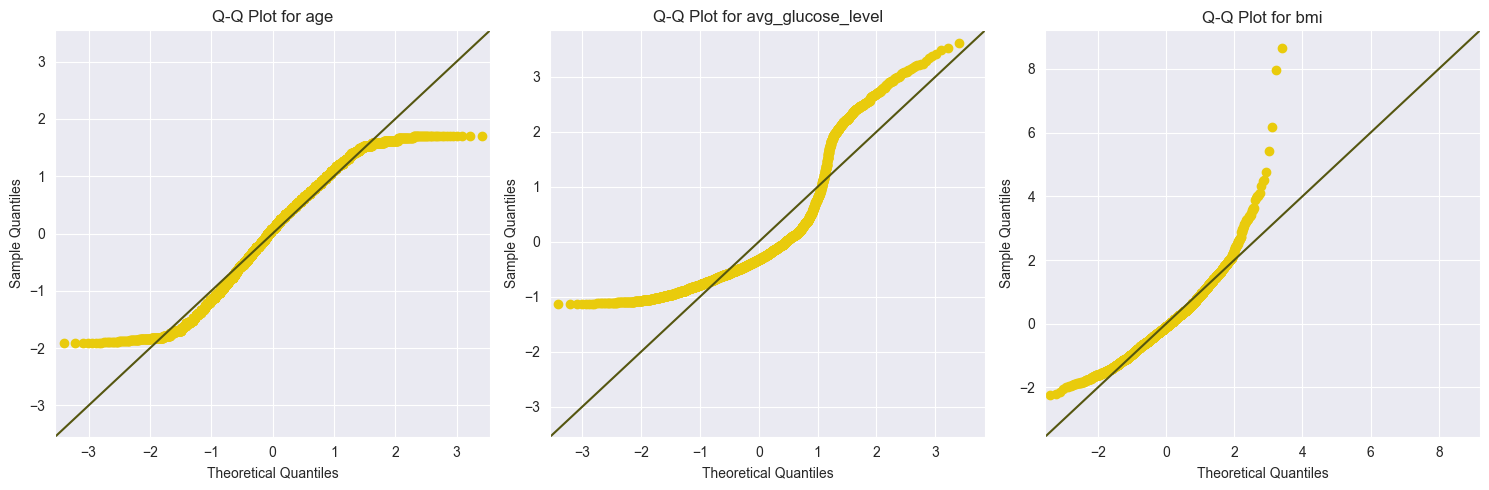

In [18]:
plot.qq_plots(X_train_pipelined, ["age", "avg_glucose_level", "bmi"])

In [19]:
stats.check_normality(X_train_pipelined,["age", "avg_glucose_level", "bmi"])

Shapiro-Wilkes test for age:
  - Statistic: 0.967
  - P-value: 0.000
  - Comment: The data for 'age' likely does not follow a normal distribution (reject H0).


Shapiro-Wilkes test for avg_glucose_level:
  - Statistic: 0.809
  - P-value: 0.000
  - Comment: The data for 'avg_glucose_level' likely does not follow a normal distribution (reject H0).


Shapiro-Wilkes test for bmi:
  - Statistic: 0.945
  - P-value: 0.000
  - Comment: The data for 'bmi' likely does not follow a normal distribution (reject H0).




The pursuit of normality: a quixotic quest in the land of skewed distributions and unruly outliers. Our numerical features, alas, have failed the normality tests. But fear not, for our models shall not be constrained by the tyranny of the Gaussian curve. They shall boldly traverse the wilds of non-normality, armed with algorithms and a healthy dose of skepticism.

In [20]:
stats.test_median_difference(df, "age", "stroke")
stats.test_median_difference(df, "bmi", "stroke")
stats.test_median_difference(df, "avg_glucose_level", "stroke")

Mann-Whitney U test for 'age' between groups in 'stroke':
  - Statistic: 1010125.500
  - P-value: 0.000
  - Comment: Significant difference in median 'age' between groups (reject H0).
Mann-Whitney U test for 'bmi' between groups in 'stroke':
  - Statistic: 569021.500
  - P-value: 0.000
  - Comment: Significant difference in median 'bmi' between groups (reject H0).
Mann-Whitney U test for 'avg_glucose_level' between groups in 'stroke':
  - Statistic: 739150.000
  - P-value: 0.000
  - Comment: Significant difference in median 'avg_glucose_level' between groups (reject H0).


The Mann-Whitney U test: the champion of non-parametric analysis, reveals a shocking truth—our stroke and non-stroke groups dare to disagree on 'age', 'bmi', and 'avg_glucose_level'.  A statistical conspiracy?  Or just another data quirk to fuel our sardonic curiosity?

In [ ]:
stats.calculate_confidence_intervals(df, "age")
stats.calculate_confidence_intervals(df, "age", "stroke")

stats.calculate_confidence_intervals(df, "bmi")
stats.calculate_confidence_intervals(df, "bmi", "stroke")

stats.calculate_confidence_intervals(df, "avg_glucose_level")
stats.calculate_confidence_intervals(df, "avg_glucose_level", "stroke")

### Confidence Intervals: Where Uncertainty Reigns Supreme

Our data, the master of ambiguity, prefers vague ranges to precise values. A fitting metaphor for life itself, wouldn't you say?

**Key takeaways (or, "educated guesses"):**

*   **Age:**  The older you get, the more likely you are to have a stroke.  Groundbreaking, I know.
*   **BMI:**  A slightly higher BMI in the stroke group.  Perhaps a fondness for donuts is a risk factor?
*   **Average Glucose Level:**  The stroke group seems to have a penchant for sugar.  A sweet tooth, or a prelude to disaster?

Confidence intervals: those statistical teasers that hint at potential relationships without any real commitment. Because who needs certainty when you can have speculation?

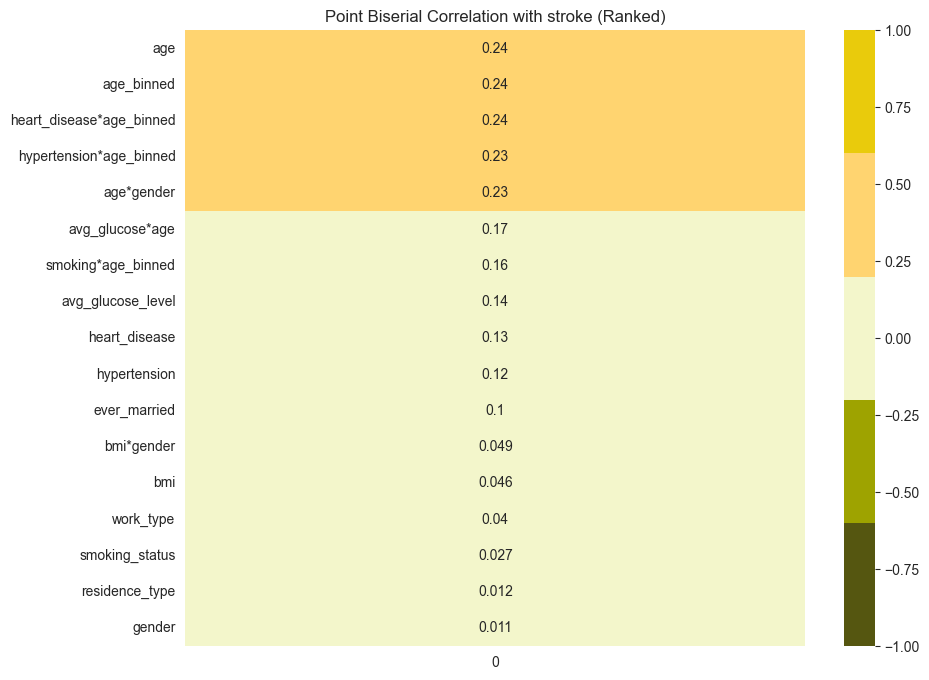

In [22]:
pipelined_df = X_train_pipelined
pipelined_df = pipelined_df.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
df_combined = pd.concat([pipelined_df, y_train], axis=1)

plot.point_biserial_heatmap(df_combined, "stroke")

Ah, the Point Biserial correlation heatmap, a tapestry of relationships woven from data and statistics.  It seems that age is indeed a worthy predictor of stroke, a fact that surprises no one.  But wait, there's more!  The interaction between `age` and `gender` also appears to be significant, suggesting that the relationship between age and stroke might be a bit more nuanced than we initially thought.  And let's not forget the contributions of `avg_glucose_level`, `heart_disease`, and `hypertension

## Baseline modeling

The baseline model: our humble starting point, the punching bag against which we measure our progress. We secretly hope it performs abysmally, setting the stage for our triumphant models to shine. But even if it surprises us with a modicum of success, we shall not despair. After all, who needs a high-performing baseline when you can have the satisfaction of surpassing it?

In [23]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

Stratified cross-validation: the data partitioning scheme that ensures every fold gets its fair share of imbalance. Because who needs simple random splits when you can have meticulously stratified ones? A noble pursuit, indeed, but let's not get carried away. Even the most sophisticated cross-validation techniques can't save us from the perils of flawed models and unruly data.

In [24]:
class_weight = {0: 1, 1: 19}

weighted_logistic_model = LogisticRegression(max_iter=1000,
                                             class_weight=class_weight)
stratified_dummy = DummyClassifier(strategy="stratified")
models = [weighted_logistic_model, stratified_dummy]

The dummy classifier: our baseline model, the embodiment of "just guessing." A stark reminder that even random chance can stumble upon a modicum of success. But fear not, for we shall also unleash the mighty Logistic Regression, armed with weighted class parameters to combat the dreaded imbalance. A true clash of the titans, where we secretly hope both contenders falter and pave the way for more entertaining models.

In [25]:
results_df = f.evaluate_models(
    models=models,
    X_train=X_train_pipelined,
    y_train=y_train,
    cv=cv,
    scoring="recall",
    n_jobs=8,
)
results_df
print(f"The mean recall:\n{results_df.mean().round(4)}")

The mean recall:
LogisticRegression class predictor    0.7433
DummyClassifier class predictor       0.0533
dtype: float64


## Undersampling

Undersampling: the art of data decimation in the name of balance. We shall bravely sacrifice those non-stroke data points, those overrepresented members of the dataset. A noble sacrifice, indeed, but let's not get carried away. After all, who needs perfect balance when you can have slightly less imbalance?

In [26]:
X_train_resampled, y_train_resampled =\
    f.undersample_data(X_train_pipelined, y_train)
X_val_resampled, y_val_resampled =\
    f.undersample_data(X_val_pipelined, y_val)

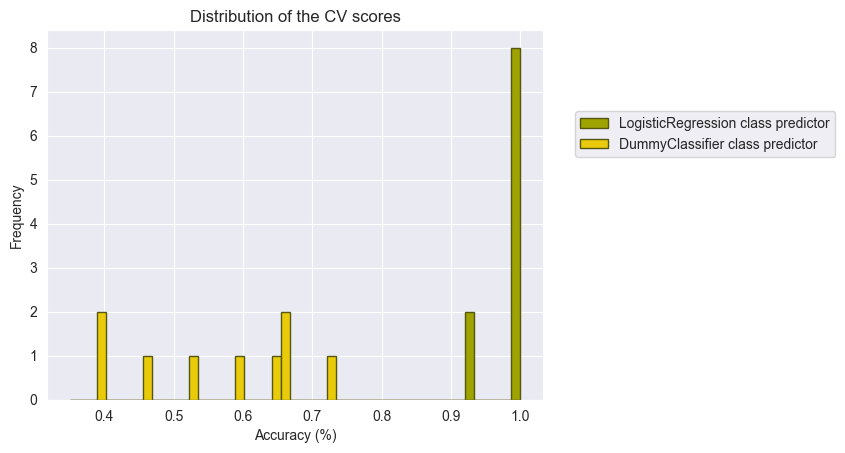

The mean recall:
LogisticRegression class predictor    0.9867
DummyClassifier class predictor       0.5443
dtype: float64


In [27]:
results_df = f.evaluate_models(
    models=models,
    X_train=X_train_resampled,
    y_train=y_train_resampled,
    cv=cv,
    scoring="recall",
    n_jobs=8,
)
plot.cv_results(results_df)
print(f"The mean recall:\n{results_df.mean().round(4)}")

Undersampling: a temporary triumph in the ongoing battle against imbalance. Our model, liberated from the tyranny of the majority class, revels in its newfound ability to detect those elusive stroke cases. But let's not get carried away. The real world, with its messy data and unpredictable outcomes, awaits.

## Ensemble Models

### Random Forest

In [28]:
balanced_rf_model = BalancedRandomForestClassifier(
    n_estimators=200,
    random_state=1,
    bootstrap=False,
    sampling_strategy="not minority",
    replacement=False,
).fit(X_train_resampled, y_train_resampled)

Ensemble Random Forest, you say? A veritable army of decision trees, united in their quest for predictive dominance. And we shall focus their collective might on the elusive recall metric, that measure of our model's ability to sniff out those rare and precious stroke cases. A noble pursuit, indeed, but let's not get carried away. After all, even the most sophisticated ensemble models can fall prey to the perils of overfitting and the capricious nature of real-world data.

In [29]:
result = permutation_importance(
    balanced_rf_model,
    X_val_resampled,
    y_val_resampled,
    n_repeats=100,
    random_state=42,
    scoring="recall",
)

importances = result.importances_mean
feature_names = X_val_pipelined.columns

importance_df = pd.DataFrame({"Feature": feature_names,
                              "Importance": importances})

importance_df = importance_df.sort_values(by="Importance", ascending=False)
importance_df

,Feature,Importance
11,age*gender,0.0958
8,age,0.0350
3,heart_disease,0.0126
1,gender,0.0092
5,work_type,0.0076
2,hypertension,0.0038
14,heart_disease*age_binned,-0.0020
13,hypertension*age_binned,-0.0046
16,avg_glucose*age,-0.0064
0,age_binned,-0.0070


Permutation importance: the art of disrupting data to unveil feature relevance. Our Random Forest, it seems, favors the intricate dance of `Age*gender` and the stoic presence of `age`. But let's not overinterpret these findings. After all, even irrelevant features can occasionally stumble into the spotlight of importance, if only by chance.

### XGBoost

In [30]:
clf_xgb = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    enable_categorical=True,
    verbosity=0,
    missing=np.nan,
    seed=42,
    scale_pos_weight=20,
)
clf_xgb.fit(
    X_train_resampled,
    y_train_resampled,
    verbose=20,
    eval_set=[(X_val_resampled, y_val_resampled)],
)

[0]	validation_0-aucpr:0.78420
[20]	validation_0-aucpr:0.72247
[40]	validation_0-aucpr:0.71832
[60]	validation_0-aucpr:0.72717
[80]	validation_0-aucpr:0.71096
[99]	validation_0-aucpr:0.70631


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

XGBoost, the heavyweight champion of gradient boosting, enters the ring. We shall unleash its power, fine-tuned for maximum recall, and watch as it grapples with the elusive stroke predictions. Will it emerge victorious, or will it succumb to the perils of overfitting and the curse of dimensionality? Only time will tell.

<Figure size 1200x1200 with 0 Axes>

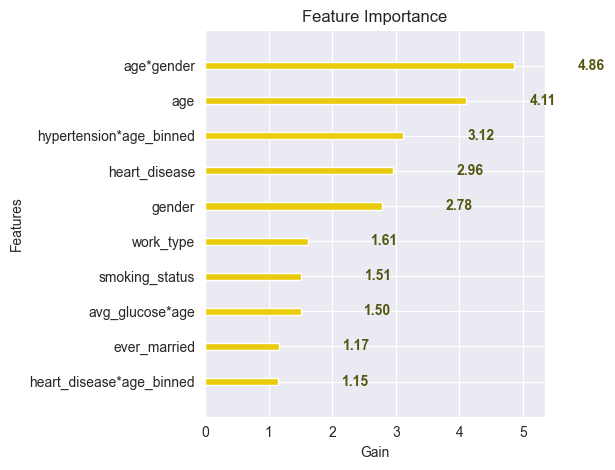

In [31]:
bst = clf_xgb.get_booster()

plt.figure(figsize=(12, 12))

xgb.plot_importance(
    bst,
    importance_type="gain",
    max_num_features=10,
    title="Feature Importance",
    xlabel="Gain",
    ylabel="Features",
    show_values=True,
    grid=True,
    color=CITRINE,
)
ax = plt.gca()
for text in ax.texts:
    text.set_text(f"{float(text.get_text()):.2f}")
    text.set_color(MOSS)
    text.set_weight("bold")
plt.tight_layout()

XGBoost, the sage of feature importance, has declared `age*gender` and `age` the reigning champions of prediction. But hold on! Our engineered feature, `hypertension*age_binned`, emerges from obscurity to claim a spot on the podium. A stroke of genius, or a fortunate fluke? The data, in its infinite wisdom, remains silent.

In [32]:
models2 = [clf_xgb, balanced_rf_model]
results_rf_vs_xgb = f.evaluate_models(
    models=models2,
    X_train=X_train_resampled,
    y_train=y_train_resampled,
    cv=cv,
    scoring="recall",
    n_jobs=8,
)
results_rf_vs_xgb
print(f"The mean recall:\n{results_rf_vs_xgb.mean().round(4)}")

The mean recall:
XGBClassifier class predictor                     0.8524
BalancedRandomForestClassifier class predictor    0.7857
dtype: float64


The Tree-Off: Random Forest vs. XGBoost, a clash of the titans! XGBoost emerges from the fray with a symphony of predictive clarity, while Random Forest stumbles with its chaotic scribbles. But let's not celebrate prematurely. Even the most elegant patterns can be deceptive, mere mirages in the vast desert of data.

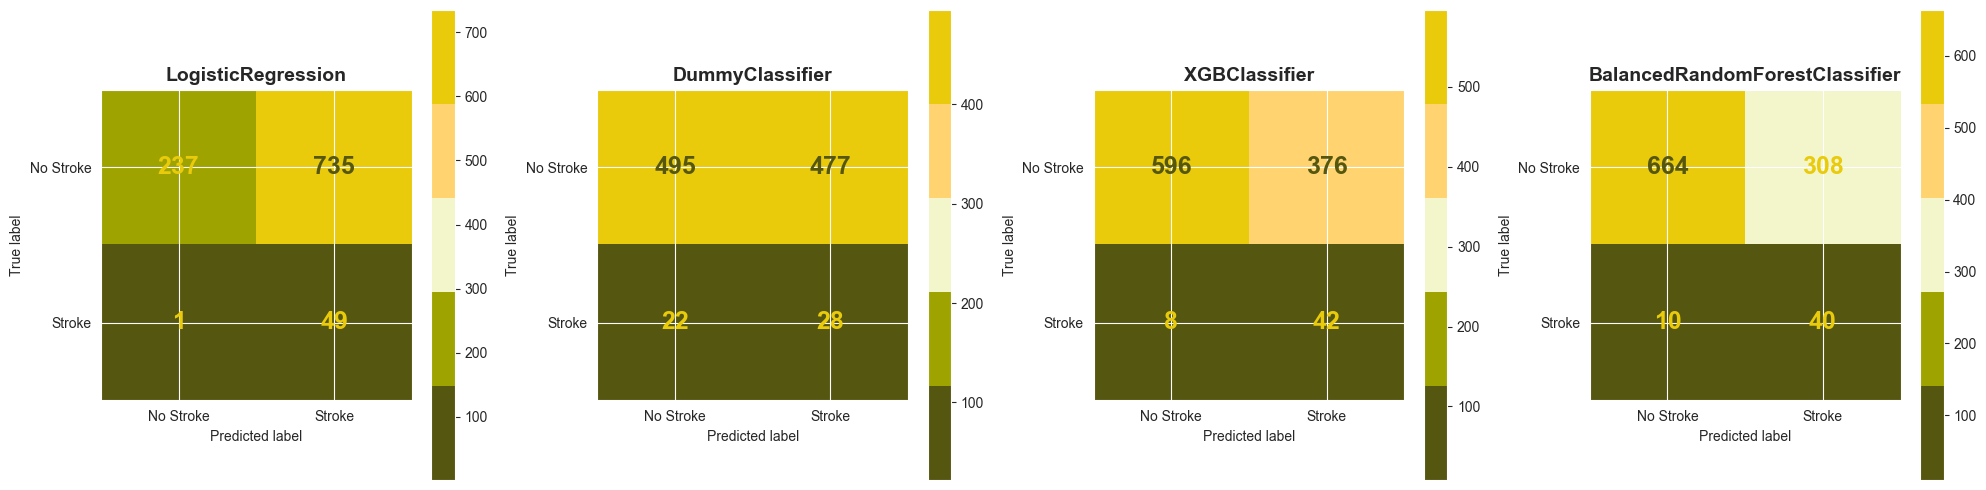

In [33]:
weighted_logistic_model.fit(X_train_resampled, y_train_resampled)
stratified_dummy.fit(X_train_resampled, y_train_resampled)

display_labels = ["No Stroke", "Stroke"]
models_list = [weighted_logistic_model, stratified_dummy,
               clf_xgb, balanced_rf_model]

plot.multi_conf_matrix(models_list, X_test_pipelined, y_test, display_labels)

Unhyperparameterized models: the underdogs of the machine learning world, those raw talents untouched by the seductive allure of optimization. Logistic Regression, the epitome of simplicity, reigns supreme in the recall arena. But XGBoost, the complex behemoth of boosting algorithms, is hot on its heels. A worthy contender, indeed, but we shall not succumb to its siren song of complexity. Instead, we shall focus our tuning efforts on the tree-based models, those chaotic ensembles of decision-making prowess. Because who needs simplicity when you can have a forest of complexity?

## Hyperparameter Tuning

In [34]:
param_grid_xgb = {
    "max_depth": [3, 4, 5],
    "learning_rate": [1, 0.1, 0.05, 0.01],
    "gamma": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "reg_lambda": [0, 0.1, 0.2, 0.3, 1.0, 5.0, 10.0],
    "scale_pos_weight": [1, 3, 5, 10, 15, 19, 20],
}
param_grid_rf = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False],
}

In [35]:
random_search = RandomizedSearchCV(
    estimator=clf_xgb,
    param_distributions=param_grid_xgb,
    n_iter=200,
    scoring="recall",
    verbose=0,
    cv=10,
    random_state=42,
    n_jobs=8,
)

random_search.fit(
    X_train_resampled,
    y_train_resampled,
    verbose=0,
    eval_set=[(X_val_resampled, y_val_resampled)],
)

print("Best parameters found: ", random_search.best_params_)
print("Best recall score: ", random_search.best_score_)

Best parameters found:  {'scale_pos_weight': 15, 'reg_lambda': 5.0, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.8}
Best recall score:  0.9866666666666667


In [36]:
clf_xgb_tuned = xgb.XGBClassifier(
    seed=1,
    objective="binary:logistic",
    scale_pos_weight=15,
    reg_lambda=5.0,
    max_depth=4,
    enable_categorical=True,
    learning_rate=0.01,
    gamma=0.8,
    eval_metric="aucpr",
)
clf_xgb_tuned.fit(
    X_train_resampled,
    y_train_resampled,
    verbose=10,
    eval_set=[(X_val_resampled, y_val_resampled)],
)

[0]	validation_0-aucpr:0.73966
[10]	validation_0-aucpr:0.79244
[20]	validation_0-aucpr:0.79168
[30]	validation_0-aucpr:0.78896
[40]	validation_0-aucpr:0.79276
[50]	validation_0-aucpr:0.79166
[60]	validation_0-aucpr:0.78736
[70]	validation_0-aucpr:0.78400
[80]	validation_0-aucpr:0.78253
[90]	validation_0-aucpr:0.78244
[99]	validation_0-aucpr:0.78231


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='aucpr', feature_types=None,
              gamma=0.8, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
random_search = RandomizedSearchCV(
    estimator=balanced_rf_model,
    param_distributions=param_grid_rf,
    n_iter=200,
    scoring="recall",
    cv=10,
    random_state=42,
    n_jobs=8,
)

random_search.fit(X_val_resampled, y_val_resampled)

print("Best parameters found: ", random_search.best_params_)
print("Best recall score: ", random_search.best_score_)

Best parameters found:  {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5, 'bootstrap': True}
Best recall score:  0.9199999999999999


In [38]:
tuned_rf_model = BalancedRandomForestClassifier(
    n_estimators=400,
    random_state=1,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features="sqrt",
    max_depth=5,
    bootstrap=False,
).fit(X_train_resampled, y_train_resampled)

## Model Evaluation

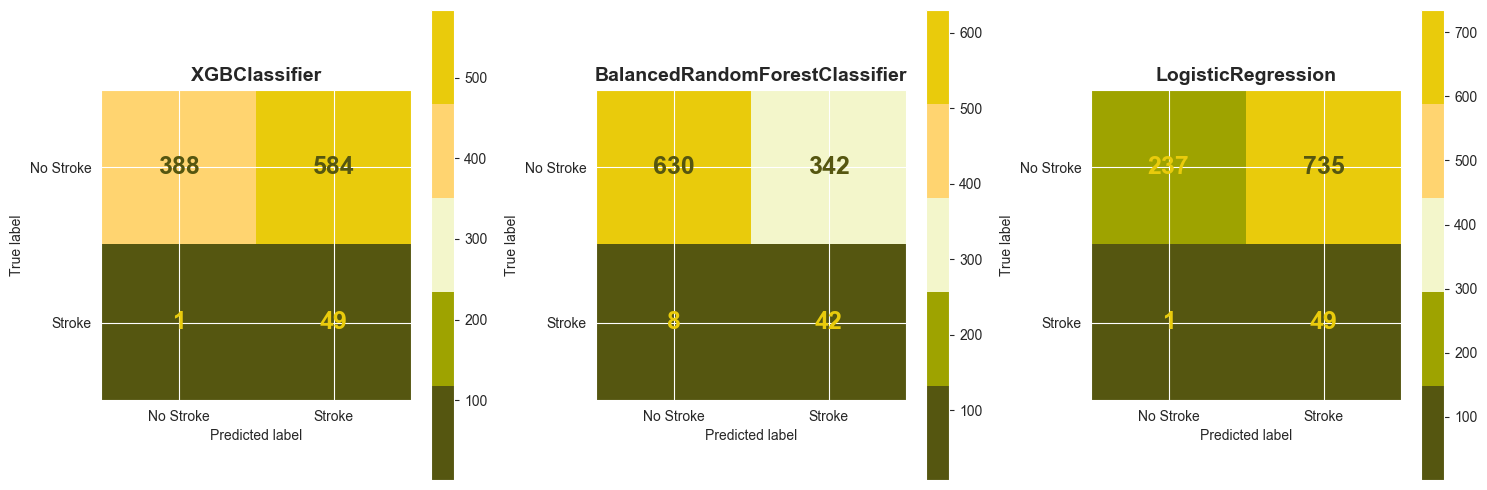

In [39]:
best_models = [clf_xgb_tuned, tuned_rf_model, weighted_logistic_model]
plot.multi_conf_matrix(best_models, X_test_pipelined, y_test, display_labels)

Hyperparameter tuning: the desperate gamble where we throw random parameters at our models and pray for a miracle. Random Forest, despite its noble efforts, limps across the finish line with a recall of 42/50. But fear not, for XGBoost and Logistic Regression emerge as champions, both boasting a near-perfect 49/50.

But wait! There's a twist. Random Forest, it seems, excels at predicting the absence of stroke. A commendable achievement, to be sure, but we shall not be swayed. We shall prioritize the detection of those life-altering stroke events, even if it means sacrificing a few accurate non-stroke predictions along the way. Because who needs balanced accuracy when you can have life-saving predictions?

In [40]:
node_params = {"shape": "box", "style": "filled, rounded", "fillcolor": APPLE}
leaf_params = {"shape": "box", "style": "filled", "fillcolor": CITRINE}

edge_params = {"color": MOSS}
graph = xgb.to_graphviz(
    clf_xgb_tuned,
    num_trees=0,
    size="1,1",
    condition_node_params=node_params,
    leaf_node_params=leaf_params,
)
image_path = os.path.join("..", "images", "xgboost_tree")
graph.render(filename=image_path, format="png") 

'../images/xgboost_tree.png'

## XGBoost Visualization
* Visualized the XGBoost tree structure.


![XGBoost Tree Visualization](../images/xgboost_tree.png)

## Model Saving

* Saved the tuned XGBoost model and pipeline for future use.

In [41]:
models_dir = Path("../models")
models_dir.mkdir(parents=True, exist_ok=True)

xgb_model_path = models_dir / "xgb_model.pkl"
with open(xgb_model_path, "wb") as f:
    pickle.dump(clf_xgb_tuned, f)

pipeline_path = models_dir / "pipeline.pkl"
with open(pipeline_path, "wb") as f:
    pickle.dump(pipeline, f)

## Conclusion
* Triumph Over Data Chaos

Through a whirlwind of data wrangling, statistical shenanigans, and model mayhem, we've emerged victorious (or at least, not entirely defeated). Our tuned XGBoost and Logistic Regression models, with their impressive recall scores, stand ready to assist in the noble cause of stroke prediction. While the journey was fraught with imbalance, outliers, and the occasional bout of hyperparameter-induced hysteria, we persevered, proving that even the most chaotic data can be tamed with a mix of ingenuity and sardonic wit.